In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers import Normalization
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras.utils as image

from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization, Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg19 import VGG19
from keras import models, layers, optimizers, regularizers, callbacks
from sagemaker.amazon.amazon_estimator import image_uris
from tensorflow.keras import backend as K
from keras import backend as K
from platform import python_version
from keras.preprocessing.image import ImageDataGenerator
import gc
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tarfile
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
import glob

In [2]:
K.set_image_data_format('channels_last')

In [3]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, 224, 224)
else:
    input_shape = (224, 224, 3)

In [4]:
input_shape

(224, 224, 3)

In [5]:
# tensorflow version
print('tensorflow: %s' % tf.__version__)
# keras version
print('keras: %s' % tf.keras.__version__)

tensorflow: 2.11.0
keras: 2.11.0


In [6]:
print(python_version())

3.10.8


In [7]:
rootPath = 'Garbage_Collection'

In [8]:
garbageImageData = rootPath+'/Garbage classification/'

In [9]:
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

base_path = garbageImageData

categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'glass'}

In [10]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  2527


In [11]:
df.head()

,filename,category
0,cardboard/cardboard252.jpg,1
1,cardboard/cardboard270.jpg,1
2,trash/trash93.jpg,4
3,paper/paper554.jpg,0
4,plastic/plastic78.jpg,2


In [12]:
df.tail()

,filename,category
2522,paper/paper277.jpg,0
2523,paper/paper412.jpg,0
2524,cardboard/cardboard391.jpg,1
2525,plastic/plastic417.jpg,2
2526,plastic/plastic63.jpg,2


In [13]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])

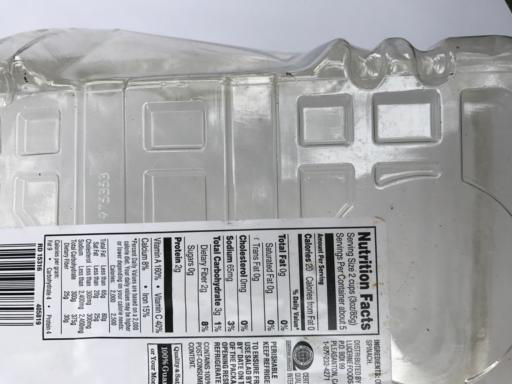

In [14]:
randomimage

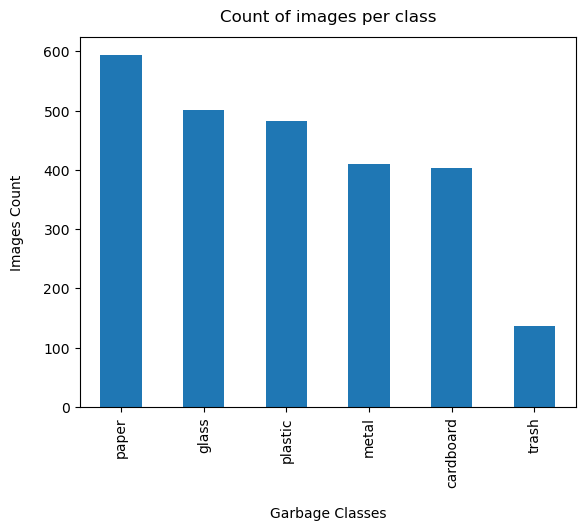

In [15]:
df_visualization = df.copy()
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [16]:
from keras.preprocessing import image

In [17]:
def is_greyScaleImage(inputImage):
    w,h = inputImage.size
    for i in range(w):
        for j in range(h):
            r,g,b = inputImage.getpixel((i,j))
            if r != g != b: return False
    return True

In [18]:
def check_grayScale(df) :
    sampleFrac = 0.4
    isGrayScaleList = []
    for imageName in df["filename"].sample(frac=sampleFrac):
        val = Image.open(base_path+'/'+imageName).convert('RGB')
        isGrayScaleList.append(is_greyScaleImage(val))
    print(np.sum(isGrayScaleList) / len(isGrayScaleList))
    del isGrayScaleList

In [19]:
check_grayScale(df)

0.0


In [20]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

2023-03-26 00:45:22.376466: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


80134624/80134624 [==============================] - 2s 0us/step


In [21]:
# freeze pre-trained network layers
for layer in vgg19.layers:
    layer.trainable = False

In [22]:
x=BatchNormalization()(vgg19.output)
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dropout(.2)(x)
x=Dense(1024,activation='relu',kernel_regularizer=keras.regularizers.L2(l2=0.0002))(x)
x=Dense(512,activation='relu')(x)
x=Dropout(.2)(x)
preds=Dense(len(categories), activation='softmax')(x)
model_vgg = Model(inputs = vgg19.input, outputs = preds)

In [23]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
# compile model
model_vgg.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['acc'])

In [25]:
df["category"] = df["category"].replace(categories) 

train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  354 validate size =  354 test size =  152


In [26]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size
)

Found 2021 validated image filenames belonging to 6 classes.


In [27]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size
)

Found 354 validated image filenames belonging to 6 classes.


In [28]:
class TrainingCheckpoint(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if logs['acc'] > 0.98:
            print("Reached target training accuracy")
            self.model.stop_training = True

In [29]:
filepath=rootPath+"/models/vgg19-{epoch:02d}-{acc:.2f}.hdf5"

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

training_checkpoint = TrainingCheckpoint()

csv_logger = keras.callbacks.CSVLogger(filename=rootPath+'/vgg19_training.csv', append=True)

In [30]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

In [31]:
batch_size

64

In [32]:
gc.collect()

3545

In [ ]:
EPOCHS = 15
history = model_vgg.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[checkpoint, csv_logger, training_checkpoint,early_stop]
)

Epoch 1/15
 7/31 [=====>........................] - ETA: 2:42 - loss: 0.6608 - acc: 0.3795

In [ ]:
model_vgg.save_weights("singularity-hackathon.h5")

In [ ]:
## Save Model
models.save_model(model_vgg, rootPath+'/singularity-hackathon.h5')

In [ ]:
pickle.dump(model_vgg, open( rootPath+'/singularity-hackathon.pkl', 'wb'))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

accuracy = model_vgg.evaluate(test_generator, steps=len(test_generator), verbose=1)

accuracy

In [ ]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

In [ ]:
preds = model_vgg.predict(test_generator, nb_samples)

preds1 = preds.argmax(1)

preds2 = [gen_label_map[item] for item in preds1]

labels = test_df['category'].to_numpy()

print(classification_report(labels, preds2))

In [ ]:
#confusion matrix
cm = confusion_matrix(test_generator.classes, preds1)
print("Confusion Matrix ")
print(cm)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
plt.rcParams["figure.figsize"] = (8,4)
sns.heatmap(cm, annot=True, fmt='d',cmap='YlGnBu', linecolor='black', linewidths=1, ax=ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix'); 

In [ ]:
tarfile_name='singularity-hackathon.tar.gz'
   
with tarfile.open(tarfile_name, mode='w:gz') as archive:
     archive.add(rootPath+'/singularity-hackathon.pkl')

In [ ]:
bucket='singularityhackathonenvironmentalprotectiondataset'
key= 'singularity-hackathon.tar.gz'

In [ ]:
import sagemaker

s3_path_to_data = sagemaker.Session().upload_data(bucket=bucket, 
                                                  path=key, 
                                                  key_prefix='models')

In [ ]:
archive

In [ ]:
test_df

In [ ]:
pickled_model = pickle.load(open(rootPath+'/singularity-hackathon.pkl', 'rb'))

In [ ]:
gen_label_map

In [ ]:
for filename in glob.glob(rootPath+'/test/*.jpg'):
    img = load_img(filename, target_size=(224, 224))
    plt.imshow(img)
    plt.show()
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds=pickled_model.predict(x)
    pred = np.argmax(preds, axis=-1) 
    preds2 = [gen_label_map[item] for item in pred]
    print(filename, preds2)

In [ ]:
XGBOOST_IMAGE = image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='1.0-1')